In [1]:
import numpy as np
import pandas as pd
import matplotlib as mlp
import matplotlib.pyplot as plt
import re
import cld3
from wordcloud import WordCloud, STOPWORDS 

## Data preparation

In [3]:
# Load csv files
f6df = pd.read_csv('f6_aggregated.csv', sep=';')
f7df = pd.read_csv('f7_aggregated.csv', sep=';')

In [4]:
# Concatenate dataframes
df = pd.concat([f6df, f7df])

In [5]:
# Add ratings
df['avg_rating'] = (df.impact_rating + df.feasibility_rating + df.auditability_rating)/3
df['avg_avg_rating'] = df.groupby('proposal_id')['avg_rating'].transform(np.mean)
dfx = df[df.result_filtered_out != 'x'].copy()
dfx['avg_avg_rating_final'] = dfx.groupby('proposal_id')['avg_rating'].transform(np.mean)

In [6]:
funds = ['F6','F7']

## Engagement

In [87]:
# Engagement
proposals = [df[df.fund == fund]['proposal_id'].value_counts().count() for fund in funds]
cas = [df[df.fund == fund]['assessor'].value_counts().count() for fund in funds]
vcas = [61, 112] # from google sheet tab
participation = pd.DataFrame.from_records([proposals, cas, vcas], index=['Proposals','CAs','vCAs'], columns=funds).T

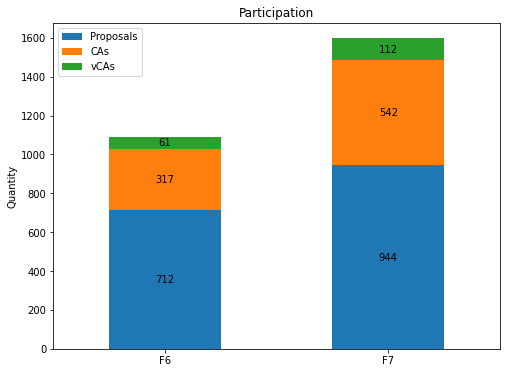

In [71]:
ax = participation.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0, ylabel='Quantity', title="Participation")
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=[int(x) for x in labels], label_type='center')

## Proposal's quality

In [55]:
# Proposal's quality
good = [dfx[np.logical_and(dfx.fund == fund, dfx.avg_avg_rating_final >=4)]['proposal_id'].value_counts().count() / dfx[dfx.fund == fund]['proposal_id'].value_counts().count() for fund in funds] 
regular = [dfx[np.logical_and(np.logical_and(dfx.fund == fund, dfx.avg_avg_rating_final <4),dfx.avg_avg_rating_final >=3)]['proposal_id'].value_counts().count() /dfx[dfx.fund == fund]['proposal_id'].value_counts().count() for fund in funds]
bad = [dfx[np.logical_and(dfx.fund == fund, dfx.avg_avg_rating_final < 3)]['proposal_id'].value_counts().count() / dfx[dfx.fund == fund]['proposal_id'].value_counts().count() for fund in funds]


proposal_qa = pd.DataFrame.from_records([good, regular, bad], index=['Score > 4','Score between 3 and 4','Score < 3'], columns=funds).T

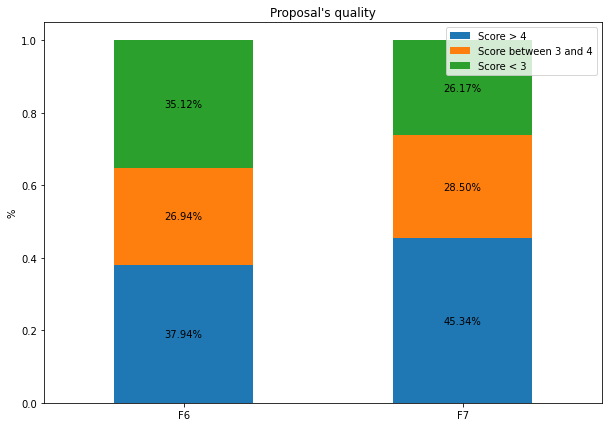

In [72]:
ax = proposal_qa.plot(kind='bar', stacked=True, figsize=(10, 7), rot=0, ylabel='%', title="Proposal's quality",mark_right = True)
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=["{:.2f}%".format(x*100) for x in labels] , label_type='center')

## CA's workload

In [78]:
# CA's quality

assessment_excellent = [df[np.logical_and(df.fund == fund, df.result_excellent == 'x')]['assesment_id'].count()  for fund in funds] 
assessment_good = [df[np.logical_and(df.fund == fund, df.result_good == 'x')]['assesment_id'].count()  for fund in funds] 
assessment_filtered_out = [df[np.logical_and(df.fund == fund, df.result_filtered_out == 'x')]['assesment_id'].count()  for fund in funds] 
assessment_qa = pd.DataFrame.from_records([assessment_excellent, assessment_good, assessment_filtered_out], index=['Excellent','Good','Filtered out'], columns=funds).T

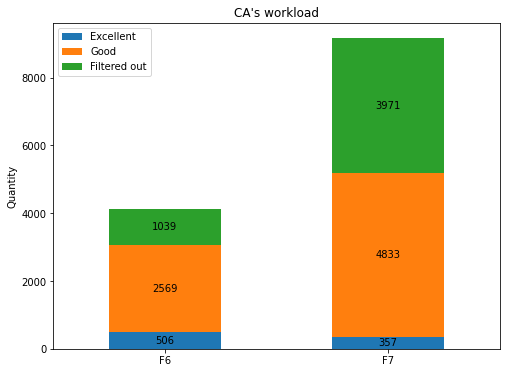

In [85]:
ax = assessment_qa.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0, ylabel='Quantity', title="CA's workload")
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=[int(x) for x in labels], label_type='center')

## CA's quality

In [83]:
# CA's quality in percentage
assessment_excellent_per = [df[np.logical_and(df.fund == fund, df.result_excellent == 'x')]['assesment_id'].count() / df[df.fund == fund]['assesment_id'].count() for fund in funds] 
assessment_good_per = [df[np.logical_and(df.fund == fund, df.result_good == 'x')]['assesment_id'].count() / df[df.fund == fund]['assesment_id'].count()  for fund in funds] 
assessment_filtered_out_per = [df[np.logical_and(df.fund == fund, df.result_filtered_out == 'x')]['assesment_id'].count() / df[df.fund == fund]['assesment_id'].count() for fund in funds] 
assessment_qa_per = pd.DataFrame.from_records([assessment_excellent_per, assessment_good_per, assessment_filtered_out_per], index=['Excellent','Good','Filtered out'], columns=funds).T

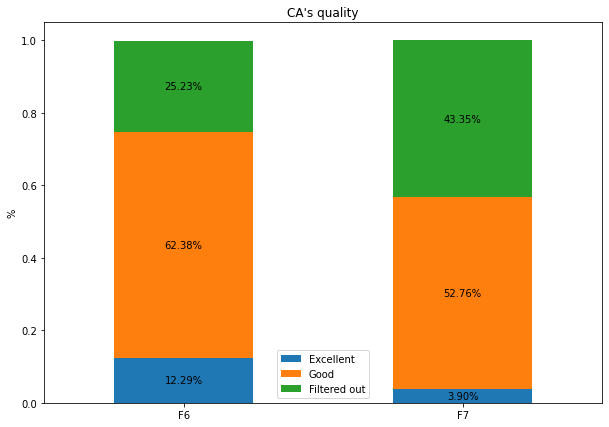

In [84]:
ax = assessment_qa_per.plot(kind='bar', stacked=True, figsize=(10, 7), rot=0, ylabel='%', title="CA's quality",mark_right = True)
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=["{:.2f}%".format(x*100) for x in labels] , label_type='center')

## vCA's workload

In [93]:
# vCA's Workload
vcarev_excellent = [df[df.fund == fund]['excellent'].sum()  for fund in funds] 
vcarev_good = [df[df.fund == fund]['good'].sum()  for fund in funds] 
vcarev_filtered_out = [df[df.fund == fund]['filtered_out'].sum()  for fund in funds] 
vcarev_qa = pd.DataFrame.from_records([vcarev_excellent, vcarev_good, vcarev_filtered_out], index=['Excellent','Good','Filtered out'], columns=funds).T

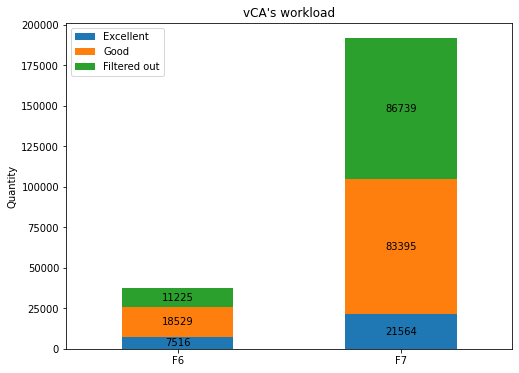

In [94]:
ax = vcarev_qa.plot(kind='bar', stacked=True, figsize=(8, 6), rot=0, ylabel='Quantity', title="vCA's workload")
for c in ax.containers:
    labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
    ax.bar_label(c, labels=[int(x) for x in labels], label_type='center')

## Additional stats

In [132]:
proposal_per_ca = np.divide(proposals,cas)
ca_per_vca = np.divide(cas,vcas)
assessments = [df[df.fund == fund]['assesment_id'].count() for fund in funds]
assesments_per_vca = np.divide(assessments,vcas)
reviews_by_ca_mean = [df[df.fund == fund]['assessor'].value_counts().mean() for fund in funds]
reviews_by_ca_median = [df[df.fund == fund]['assessor'].value_counts().median() for fund in funds]
reviews_by_vca_mean = [621.16, 1711.58] # from google sheet tab
reviews_by_vca_median = [306,711] # from google sheet tab


additional_stats = pd.DataFrame.from_records([proposals, cas, vcas, proposal_per_ca,ca_per_vca,assesments_per_vca,reviews_by_ca_mean,reviews_by_ca_median,reviews_by_vca_mean,reviews_by_vca_median], index=['Proposals','CAs','vCAs','proposals/CAs','CAs/vCAs','Assesments per vCA',"CA's assessments [mean]","CA's assessments [median]","vCA's reviews [mean]","vCA's reviews [median]"], columns=funds)
pd.options.display.float_format = "{:,.2f}".format

In [133]:
display(additional_stats)

,F6,F7
Proposals,712.00,944.00
CAs,317.00,542.00
vCAs,61.00,112.00
proposals/CAs,2.25,1.74
CAs/vCAs,5.20,4.84
Assesments per vCA,67.51,81.79
CA's assessments [mean],12.99,16.90
CA's assessments [median],5.00,4.00
vCA's reviews [mean],621.16,"1,711.58"
vCA's reviews [median],306.00,711.00
